<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-Clean-Data" data-toc-modified-id="Download-and-Clean-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and Clean Data</a></span></li><li><span><a href="#Derive-Optimal-LDA-Number-of-Topics" data-toc-modified-id="Derive-Optimal-LDA-Number-of-Topics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Derive Optimal LDA Number of Topics</a></span></li><li><span><a href="#Making-Recommendations" data-toc-modified-id="Making-Recommendations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Making Recommendations</a></span><ul class="toc-item"><li><span><a href="#BERT" data-toc-modified-id="BERT-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Doc2vec" data-toc-modified-id="Doc2vec-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Doc2vec</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#TFIDF" data-toc-modified-id="TFIDF-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>TFIDF</a></span></li></ul></li></ul></div>

In [1]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.set(rc={"figure.figsize": (15, 5)})

from wikirec import data_utils, model, utils

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:99% !important; }</style>"))

# Download and Clean Data

In [2]:
files = data_utils.download_wiki(
    language="en", target_dir="../wikirec/enwiki_dump", file_limit=-1, dump_id=False
)
len(files)

Files already available in the ../wikirec/enwiki_dump directory.


58

In [3]:
data_utils.parse_to_ndjson(
    topic="movies",
    output_path="../wikirec/enwiki_movies.ndjson",
    input_dir="../wikirec/enwiki_dump",
    partitions_dir="../wikirec/enwiki_movie_partitions",
    limit=None,
    delete_parsed_files=True,
    multicore=True,
    verbose=True,
)

Making ../wikirec/enwiki_movie_partitions directory for the partitions


Files partitioned:   0%|          | 0/59 [00:00<?, ?file/s]

File ../wikirec/enwiki_movies.ndjson with articles for the given topic saved
Deleting ../wikirec/enwiki_movie_partitions directory


In [ ]:
with open("../wikirec/enwiki_movies.ndjson", "r") as fin:
    movies = [json.loads(l) for l in fin]

print(f"Found a total of {len(movies)} movies.")

In [9]:
titles = [m[0] for m in movies]
texts = [m[1] for m in movies]

In [10]:
text_corpus, token_corpus, selected_idxs = data_utils.clean(
    texts=texts,
    min_token_freq=2,
    min_token_len=3,
    min_tokens=0,
    max_token_index=-1,
    remove_names=True,
    sample_size=1,
    verbose=True,
)

titles = [titles[i] for i in selected_idxs]

Cleaning steps complete:   0%|          | 0/7 [00:00<?, ?steps/s]

# Derive Optimal LDA Number of Topics

LDA models ran:   0%|          | 0/12 [00:00<?, ?it/s]

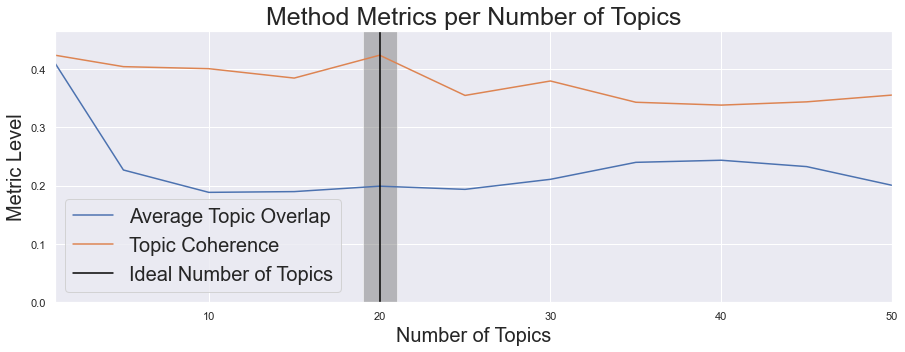

In [29]:
topic_nums_to_compare = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

utils.graph_lda_topic_evals(
    corpus=token_corpus,
    num_topic_words=10,
    topic_nums_to_compare=topic_nums_to_compare,
    metrics=True,
    verbose=True,
)

plt.show()

# Making Recommendations

Note that the `text_corpus` is passed for BERT, Doc2vec, and TFIDF, but the `token_corpus` is passed to LDA.

In [ ]:
inputs = ["The Godfather", "The Dark Knight"]

## BERT

In [23]:
# We can pass kwargs for sentence_transformers.SentenceTransformer.encode
bert_sim_matrix = model.gen_sim_matrix(
    method="bert",
    metric="cosine",
    corpus=text_corpus,
    bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
)

In [24]:
model.recommend(
    inputs=inputs, titles=titles, sim_matrix=bert_sim_matrix, n=10,
)

[['The Love Trap', 0.9488186],
 ['Rosie!', 0.93960285],
 ['Valet Girls', 0.91204715],
 ['10:10', 0.8811502],
 ['Sema Ragalai', 0.8686013],
 ['The Nickel-Hopper', 0.8544489],
 ["The Rake's Progress", 0.85347676],
 ['Secret Ingredient', 0.8496946],
 ['Invisibles', 0.8361241],
 ['Paulo Roberto Cotechiño centravanti di sfondamento', 0.83566755]]

## Doc2vec

In [25]:
# We can pass kwargs for gensim.models.doc2vec.Doc2Vec
doc2vec_sim_matrix = model.gen_sim_matrix(
    method="doc2vec", metric="cosine", corpus=text_corpus
)

In [26]:
model.recommend(
    inputs=inputs, titles=titles, sim_matrix=doc2vec_sim_matrix, n=10,
)

[['Invisibles', 0.7893594798896474],
 ['Curtain Call', 0.7393965651678354],
 ['The Love Trap', 0.727949916490964],
 ['Rosie!', 0.7047266447752335],
 ['I Want to Be a Chorus Girl', 0.6893568568272742],
 ['Scene of the Crime', 0.67100570477152],
 ['Police Bullets', 0.6567080003572627],
 ['10:10', 0.6451552405100502],
 ['Banished', 0.6428815395556589],
 ['Swordsmen in Double Flag Town', 0.6218292696884203]]

## LDA

In [19]:
# We can pass kwargs for gensim.models.ldamulticore.LdaMulticore
lda_sim_matrix = model.gen_sim_matrix(
    method="lda", metric="cosine", corpus=token_corpus, num_topics=35,
)

In [20]:
model.recommend(
    inputs=inputs, titles=titles, sim_matrix=lda_sim_matrix, n=10,
)

[['The Saddle Buster', 1.0],
 ['Oasis of the Zombies', 1.0],
 ['Curtain Call', 1.0],
 ["My Family's Beautiful!", 1.0],
 ['The Love Trap', 1.0],
 ['José', 1.0],
 ['10:10', 0.94733196],
 ['The Dead and the Damned', 0.88816935],
 ['The Mall, The Merrier', 0.6097185],
 ['I Want to Be a Chorus Girl', 0.5968604]]

## TFIDF

In [27]:
# We can pass kwargs for sklearn.feature_extraction.text.TfidfVectorizer
tfidf_sim_matrix = model.gen_sim_matrix(
    method="tfidf", metric="cosine", corpus=text_corpus, max_df=1.0, min_df=1.0,
)

In [28]:
model.recommend(
    inputs=inputs, titles=titles, sim_matrix=tfidf_sim_matrix, n=10,
)

[['The Love Trap', 0.6765717615744917],
 ['Rosie!', 0.5272319150896027],
 ['The Nickel-Hopper', 0.495849732996128],
 ['Valet Girls', 0.46305453075642083],
 ['The Conspiracy', 0.4156999199183507],
 ['The Dangerous Flirt', 0.4109142602072243],
 ['Police Bullets', 0.4058402224742317],
 ['Secret Ingredient', 0.40408996326991303],
 ['10:10', 0.38373877960261327],
 ['Sons of Liberty', 0.36651363562819284]]